In [9]:
# Imports
from pymongo import MongoClient
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017')
db = client['collaborativefilteringtest']  # Database name
users_collection = db['users']
posts_collection = db['posts']
likes_collection = db['likes']
answers_collection = db['answers']  # Add answers collection    


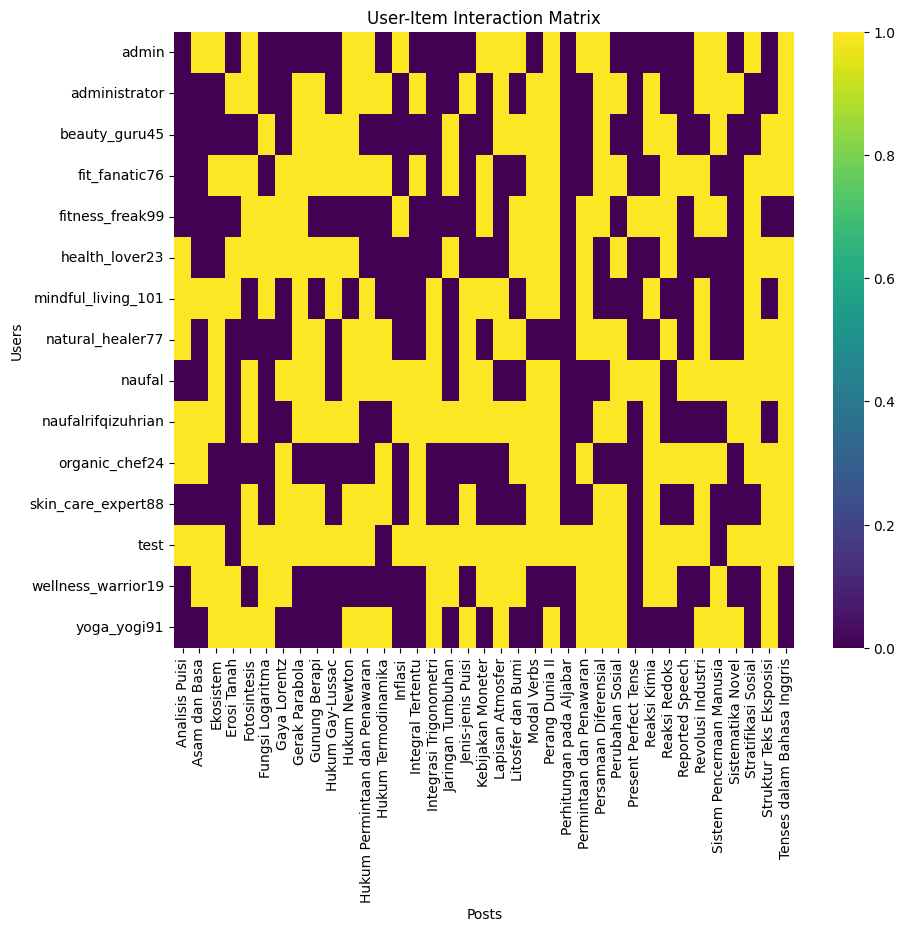

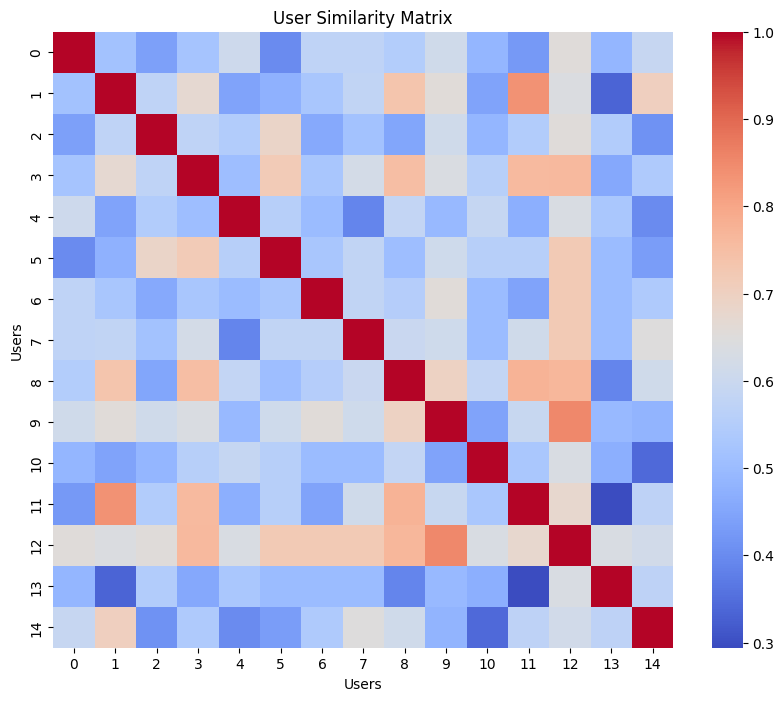

In [10]:
# Fetch data from MongoDB
users = list(users_collection.find())
posts = list(posts_collection.find())
likes = list(likes_collection.find())
answers = list(answers_collection.find())  # Fetch answers

# Create DataFrame for likes and answers
likes_df = pd.DataFrame(likes)
answers_df = pd.DataFrame(answers)

# Add a column 'interaction' to likes and answers DataFrame
likes_df['interaction'] = 1
answers_df['interaction'] = 1

# Combine likes and answers DataFrame
interactions_df = pd.concat([likes_df[['user_id', 'post_id', 'interaction']], 
                            answers_df[['user_id', 'post_id', 'interaction']]])
# Fetch post titles
post_titles = {str(post['_id']): post['title'] for post in posts}
user_username = {str(user['_id']): user['username'] for user in users}

# Replace post_id with title in interactions_df
interactions_df['post_id'] = interactions_df['post_id'].apply(lambda x: post_titles[str(x)])
interactions_df['user_id'] = interactions_df['user_id'].apply(lambda x: user_username[str(x)])

# Pivot table to create user-item matrix
user_item_matrix = interactions_df.pivot_table(index='user_id', columns='post_id', values='interaction', fill_value=0)

# Convert user-item matrix to numpy array
ratings_matrix = user_item_matrix.to_numpy()

# Calculate cosine similarity between users
user_similarity = cosine_similarity(ratings_matrix)

# Visualize the user-item matrix
plt.figure(figsize=(10, 8))
sns.heatmap(user_item_matrix, cmap='viridis', cbar=True)
plt.title('User-Item Interaction Matrix')
plt.xlabel('Posts')
plt.ylabel('Users')
plt.show()

# Visualize the user similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(user_similarity, cmap='coolwarm', cbar=True)
plt.title('User Similarity Matrix')
plt.xlabel('Users')
plt.ylabel('Users')
plt.show()

In [11]:
# Function to recommend posts for a given user based on similar users' likes
def recommend_posts(user_idx, num_recommendations=5):
    sim_scores = user_similarity[user_idx]
    similar_users = np.argsort(sim_scores)[::-1][1:]  # Exclude the user itself

    post_scores = np.zeros(ratings_matrix.shape[1])

    for similar_user in similar_users:
        post_scores += sim_scores[similar_user] * ratings_matrix[similar_user]

    post_scores[ratings_matrix[user_idx] > 0] = 0  # Remove already liked/answered posts
    recommended_post_indices = np.argsort(post_scores)[::-1][:num_recommendations]
    return post_scores, recommended_post_indices

------------------------------------------------------
recommended posts:  [ 7 21 28 26 35]
------------------------------------------------------
------------------------------------------------------
recommended posts:  [35 34  2 24 20]
------------------------------------------------------
------------------------------------------------------
recommended posts:  [31 26  4 34 24]
------------------------------------------------------
------------------------------------------------------
recommended posts:  [28 20 19 17 24]
------------------------------------------------------
------------------------------------------------------
recommended posts:  [36 10 35 26  2]
------------------------------------------------------
------------------------------------------------------
recommended posts:  [25 31 28  2 19]
------------------------------------------------------
------------------------------------------------------
recommended posts:  [10 25 26  4 35]
--------------------------

C:\Users\estar\AppData\Local\Temp\ipykernel_3460\3403878559.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=user_item_matrix.columns, y=post_scores, palette='viridis')


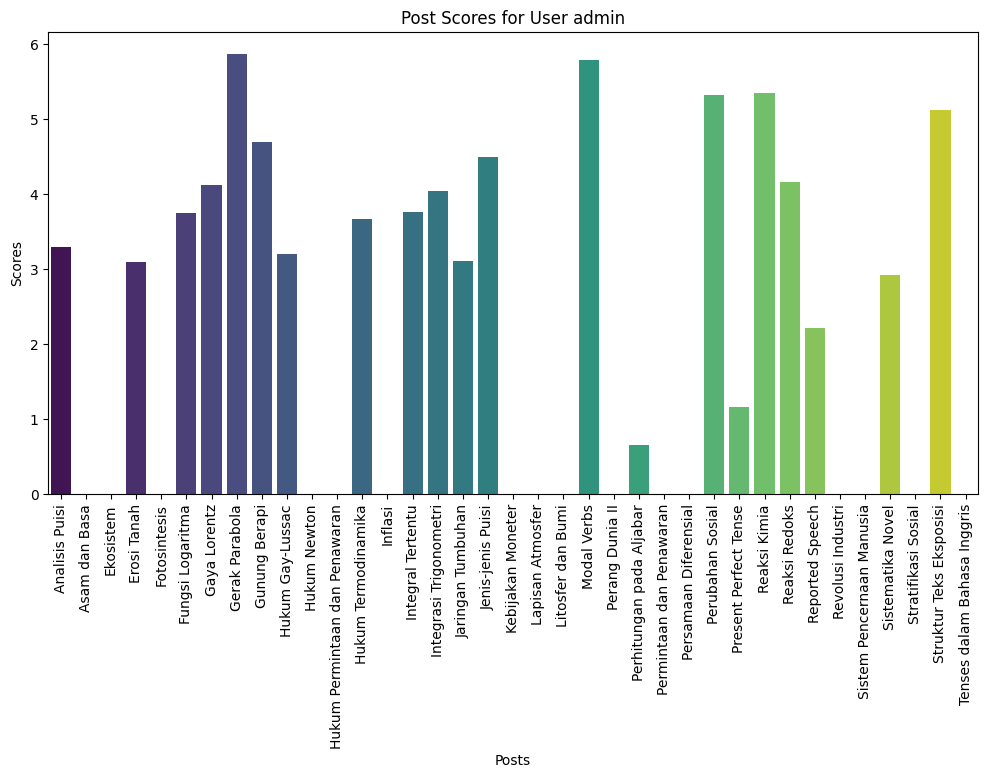

In [12]:
recommendations = {}
post_scores_dict = {}
for user_id in user_item_matrix.index:
    user_idx = list(user_item_matrix.index).index(user_id)
    post_scores, recommended_posts = recommend_posts(user_idx, num_recommendations=5)
    print('------------------------------------------------------')
    print('recommended posts: ', recommended_posts)
    print('------------------------------------------------------')
    recommended_post_ids = [user_item_matrix.columns[post_idx] for post_idx in recommended_posts]
    recommendations[str(user_id)] = recommended_post_ids
    post_scores_dict[str(user_id)] = post_scores.tolist()  # Save the scores as a list

# Save recommendations to a JSON file
with open('recommendations-test.json', 'w') as f:
    json.dump(recommendations, f)

# Save post scores to a JSON file
with open('post_scores-test.json', 'w') as f:
    json.dump(post_scores_dict, f)

# Visualize the post scores for the first user
user_id = list(user_item_matrix.index)[0]
user_idx = list(user_item_matrix.index).index(user_id)
post_scores, _ = recommend_posts(user_idx, num_recommendations=5)

plt.figure(figsize=(12, 6))
sns.barplot(x=user_item_matrix.columns, y=post_scores, palette='viridis')
plt.title(f'Post Scores for User {user_id}')
plt.xlabel('Posts')
plt.ylabel('Scores')
plt.xticks(rotation=90)
plt.show()